# Data Analysis

## Setup

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import squarify

In [2]:
pd.set_option("display.precision", 3)
pd.set_option('future.no_silent_downcasting', True)

## Transactions by Residency

Since the data is really similar for buyers and seller, we'll focus on the buyers for clarity.

### Preprocessing

In [3]:
# read the data from json and parse MKOOD (unique id of the county) as string
df_raw = pd.read_json(
    "../app/public/data/transactions_by_residency_of_buyers_county_level.json",
    orient="columns",
    dtype={"MKOOD": str},
)
df_raw.head(3)

,MKOOD,data
0,0037,"{'2010': [{'Name': 'United States of America',..."
1,0039,"{'2010': [{'Name': 'Estonia', 'Number': 480, '..."
2,0045,"{'2010': [{'Name': 'Estonia', 'Number': 4741, ..."


In [4]:
# load the mapping from MKOOD to county name
mapping = json.load(open("../app/public/data/id_to_county.json"))
mapping

{'0037': 'Harju maakond',
 '0039': 'Hiiu maakond',
 '0045': 'Ida-Viru maakond',
 '0052': 'Järva maakond',
 '0050': 'Jõgeva maakond',
 '0056': 'Lääne maakond',
 '0060': 'Lääne-Viru maakond',
 '0068': 'Pärnu maakond',
 '0064': 'Põlva maakond',
 '0071': 'Rapla maakond',
 '0074': 'Saare maakond',
 '0079': 'Tartu maakond',
 '0081': 'Valga maakond',
 '0084': 'Viljandi maakond',
 '0087': 'Võru maakond'}

As the data has been formatted for more convenient operations in Javascript, we first need to extract the data from `data` column.

In [47]:
updated_rows = []

for i, row in df_raw.iterrows():
    county_id = row["MKOOD"]

    for year, county_data in row.data.items():

        for country_data in county_data:
            updated_rows.append(
                {
                    "county_id": county_id,
                    "county_name": mapping[county_id],
                    "year": year,
                    "country": country_data["Name"],
                    "count": country_data["Number"],
                    "total_area_ha": country_data["Total area (ha)"],
                    "total_value_eur": country_data["Total value (eur)"],
                }
            )

df = pd.DataFrame(updated_rows)

df.total_value_eur = pd.to_numeric(df.total_value_eur.replace('***', np.nan), errors='coerce')
df.total_area_ha = pd.to_numeric(df.total_area_ha.replace('***', np.nan), errors='coerce')
df.year = pd.to_numeric(df.year, errors='coerce')

# remove entries with TOTAL as the country name
df = df[df.country != "TOTAL"]

df.head(3)

,county_id,county_name,year,country,count,total_area_ha,total_value_eur
0,0037,Harju maakond,2010,United States of America,27,26.0,9.429e+05
1,0037,Harju maakond,2010,Estonia,19431,10946.0,9.234e+08
2,0037,Harju maakond,2010,Ireland,9,0.2,3.686e+05


Now there's an entry per `county`, `year` and `country` (of buyers). For every row we have statistics about:

- the number of transactions; 
- total area in hectares that has changed the owner and;
- its corresponding value in euros. 

### Analysis

When we think about he visualization, comparing the number of transactions by the residency of buyers / sellers might not give us too much insights since Estonians are naturally buying and selling most. The same applies to area in hectares. What might be interesting though is to see **how much money flows in our out from different countries to Estonian property market**.

In [48]:
df.year.min(), df.year.max()

(np.int64(2010), np.int64(2024))

In [50]:
# let's see the number of unique countries and their corresponding amounts over 14 years
df.groupby("country").total_value_eur.sum().sort_values(ascending=False).reset_index()

,country,total_value_eur
0,Estonia,5.335e+10
1,Finland,3.321e+08
2,Other residents,1.877e+08
3,Russian Federation,1.637e+08
4,France,5.902e+07
5,Germany,5.075e+07
6,United States of America,4.806e+07
7,United Kingdom,4.415e+07
8,Sweden,3.824e+07
9,Monaco,2.166e+07


### Visualizations

As can be seen from table above, naturally Estonians have spent the most, and the difference is in orders of magnitude, but at it also gives an overview of the countries most invested in the property market in Estonia. So our aim is to visualize the size of parts from the whole and for that purpose **treemap** is a perfect candidate.

In [ ]:
# filter the map to have only one certain county (Harjumaa) and year (2024)
df_plot = df[(df.county_id == "0037") & (df.year == 2024)]
df_plot = df_plot.groupby(["country"]).total_value_eur.sum().sort_values(ascending=False).reset_index()
df_plot

,country,total_value_eur
0,Estonia,3.574e+09
1,France,1.194e+07
2,Other residents,7.915e+06
3,Finland,7.838e+06
4,United States of America,3.898e+06
5,Germany,3.313e+06
6,Russian Federation,2.785e+06
7,Ukraine,1.962e+06
8,Netherlands,1.798e+06
9,United Kingdom,1.742e+06


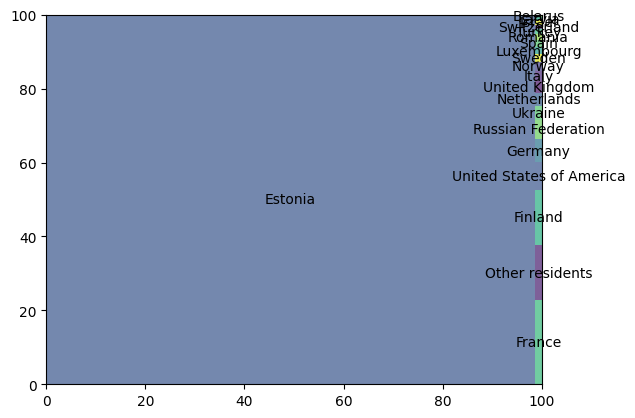

In [ ]:
# generate treemap visualization from df_plot dataframe using plt
squarify.plot(
    sizes=df_plot.total_value_eur.tolist(), 
    label=df_plot.country.tolist(), 
    alpha=0.7
)
plt.axis('on')
plt.show()

As can be seen, the value of visualization is not useful, when 1 country takes more than 90% of the whole chart. Let's remove Estonia and try again.

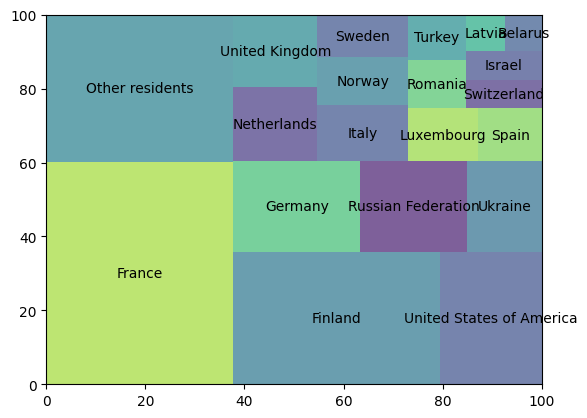

In [57]:
df_plot_wo_est = df_plot[df_plot.country != "Estonia"]
squarify.plot(
    sizes=df_plot_wo_est.total_value_eur.tolist(), 
    label=df_plot_wo_est.country.tolist(), 
    alpha=0.7
)
plt.axis('on')
plt.show()

Since we have the data for 14 years, we can visualize the changes between different years, but also compare counties and compare the nationalities and magnitudes of investments from different countries. Considering that we now remove Estonia, we could also include number of transactions and area to visualization (as dropdown for example).